## Model Training Challenge! 

In this notebook, there are a whole host of weird errors. 
Some of them will be obvious and throw an error, but some are less clear and will break things without telling you they're breaking. 
Do your best to sniff out the mistakes in both code and training procedure! 

Your mission, should you choose to accept it, is: 
* Work together in groups of 4 to complete this notebook
* Figure out all the coding mistakes and make a notebook that runs
* Find the mistakes in training and take appropriate corrective measures so the model trains well!
* Make a ~15 minute long presentation showing your results and the steps you took to find and solve them.

### Rules 
* If you cannot correct the problem, identify it and write a quick paragraph about what you would do
* You are allowed to use any resource you can find; other groups, TA's, a random scientist walking by, and most importantly, the internet. The use of generative AI is highly discouraged - not because it's cheating, but because it can send you down rabbit holes that are hard to find your way out of. 

This line below installs a non-standard data generation package. 
It is designed to make images for benchmarking computer vision problems, and is the back bone of your generator. 
Unfortunately, it's not included with colab (which makes sense....), so we have to install it. 
The `!` point here means "Execute this line like it's a line in a bash prompt". 

In [ ]:
! pip install deepbench

`curl` is a package for downloading files off the internet. 
This below line just downloads a file form the repo into this colab instance, and names it "challenge_utilities.py". 
This file is also in the github repo, you can look at it there if you want. 
It contains the data generator for each for your challenges, and the utilities for plotting and evaluating results. 
(It won't contain any problems for you to solve, it's just there to keep this notebook from getting cluttered.)

In [ ]:
! curl -o challenge_utilities.py https://raw.githubusercontent.com/BNL-Fermilab-RENEW/tutorials_2024/tree/main/07_Challenge/challenge_utilities.py

In [4]:
# Now we'll import the different classes from this new file 
from challenge_utilities import SkyGeneratorTrue as SkyGenerator # `as` renames the imported package name
from challenge_utilities import Eval

In [5]:
# Standard packages 

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dropout, Conv1D, Dense, AvgPool1D, Flatten
from tensorflow.keras.models import Model

import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler

#### Package documentation 

If you get stuck for syntax or anything - these are the packages used. 
Look up a function you're trying to use in their package search pages, and see if you maybe have types wrong, or wrong variable names. 

[Numpy](https://numpy.org/)

[MatPlotLib](https://matplotlib.org/) 

[Tensorflow/tf/Keras](https://keras.io/)

[Scikit Learn](https://scikit-learn.org/stable/index.html)

# Exploratory Data Analysis 

Understanding your data is a critical part of any AI/ML project. 
Make sure you look at your data and understand the differences between each class. 

Something to note, which you would only know if you gathered the data yourself, is that the binary "0" and "1" labels correspond to "stars" and "galaxies".
You can use this to label your plots. 

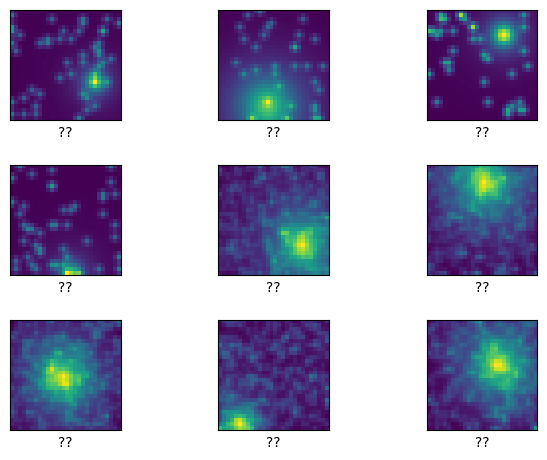

In [6]:

label_map = {
    0: "Star", 
    1: "Galaxy"
}


def plot_samples(generator, n_columns=3, n_rows=3, label_map=None): 
    _, subplots = plt.subplots(n_columns, n_rows) # Make 9 plots in a 3 x 3 grid 
    plt.tight_layout()
    plt.setp(subplots, xticks=[], yticks=[])

    for sample_index, subplot in zip(range(n_columns*n_rows), subplots.ravel()): 
        image, label = generator[sample_index]
        subplot.imshow(image.squeeze()) 
        # 'imshow' displays an image in 2d (black and white if it only has 1 color channel, or in color if it has 3 (r,g,b) color channels). 
        # Here it's green and blue because the default colorway for matplotlib is "viridis", with is all cool colors
        
        string_label = "??" 
        subplot.set_xlabel(string_label) # This gives you a label underneath the image (on the x axis)

samples = SkyGenerator(n_samples=9, batch_size=1) # Can just get a few samples
plot_samples(samples)

# Look at the input data 

Understanding the data is a critical part of the training process, let's take a look at the distributions we're working with. 

In [7]:
# These two generators produce the data we'll train with 

n_train_samples = 1280
train_generator = SkyGenerator(n_samples=n_train_samples, shuffle=True)

n_val_samples = 1280
val_generator = SkyGenerator(n_samples=n_val_samples, train=False, shuffle=True)

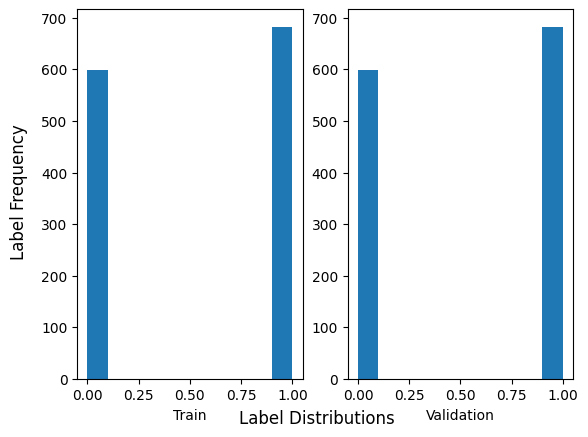

In [8]:
# We can look at the distribution of labels by grabbing them from the generator 
    # TF.Sequence generators supply data as a tuple 
    # of (x,y) (or (features, labels)) 
    # - so using index 1 we can get the labels

all_train_labels = np.array([
    train_generator[i][1] for i in range(len(train_generator))
]).ravel()

all_val_labels = np.array([
    val_generator[i][1] for i in range(len(val_generator))
]).ravel()

figure, subplots = plt.subplots(1, 2)
subplots[0].hist(all_train_labels)
subplots[0].set_xlabel("Train")

subplots[1].hist(all_val_labels)
subplots[1].set_xlabel("Validation")

figure.supxlabel("Label Distributions")
figure.supylabel("Label Frequency")

plt.show()

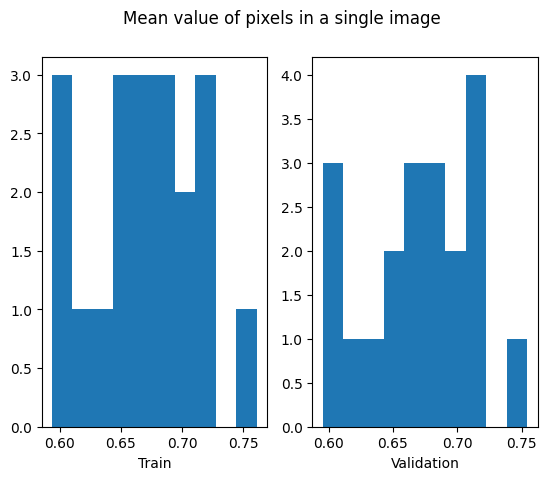

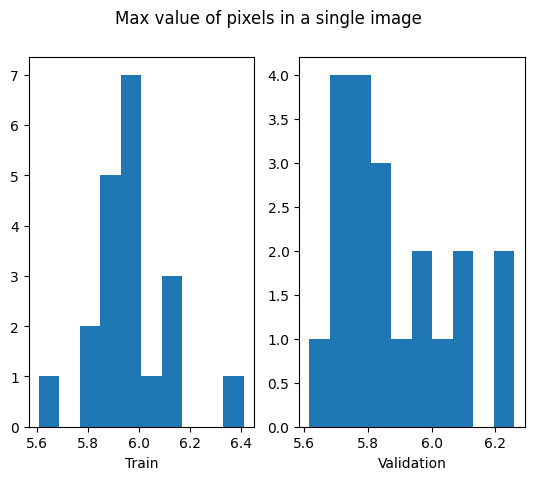

In [9]:
# We can also look at different attributes of the images 
# Here, let's look at max values and mean values

# These numbers will be slightly different every time, there's randomness controlling how the images are generated 
# In scientific settings, it's good to remove the randomness if possible, but here it's fine

all_train_labels = np.array([
    train_generator[i][0].ravel().mean() for i in range(len(train_generator))
]).ravel()

all_val_labels = np.array([
    val_generator[i][0].mean() for i in range(len(val_generator))
]).ravel()

figure, subplots = plt.subplots(1, 2)
subplots[0].hist(all_train_labels)
subplots[0].set_xlabel("Train")

subplots[1].hist(all_val_labels)
subplots[1].set_xlabel("Validation")

figure.suptitle("Mean value of pixels in a single image")
plt.show()


all_train_labels = np.array([
    train_generator[i][0].ravel().max() for i in range(len(train_generator))
]).ravel()

all_val_labels = np.array([
    val_generator[i][0].ravel().max() for i in range(len(val_generator))
]).ravel()

figure, subplots = plt.subplots(1, 2)
subplots[0].hist(all_train_labels)
subplots[0].set_xlabel("Train")

subplots[1].hist(all_val_labels)
subplots[1].set_xlabel("Validation")

figure.suptitle("Max value of pixels in a single image")
plt.show()

## Data Processing

There are many ways to help a model along when it comes to training - one of those is data pre-processing.
There are near infinite ways to pre-process, especially in the computer vision space. 
Think about it like applying different instagram filters, they have different impacts that emphasis the image in different ways. 

For this, let's try bringing all the pixels in the image between 0 and 1. 

In [10]:
scaler = MinMaxScaler((0, 1))

fit_data = np.concatenate([train_generator[i][0] for i in range(5)], axis=0) 
# This is 5 batches of data, being used to find the approximate min and max of the data
# Because our data is synthetic, we don't need to worry about big outliers

# Unfortunately, minmaxscaler only handles 1d of data, so we need to do a little pre-and-post processing on the input 
# combining the last two dimensions together, making the 2d of the image 1d instead. 
fit_data = fit_data.reshape((fit_data.shape[0], fit_data.shape[1]*fit_data.shape[2]) ) 
scaler_fit = scaler.fit(fit_data)

def processor(image): 
    # This function will take a single image and return the scaled version 
    image_flat = image.ravel() 
    image_scaled = scaler_fit.transform(image_flat.reshape(1, -1))
    # Magically reshape it back into 2d 
    image_scaled_reshaped = image_scaled.reshape(image.shape)
    return image_scaled_reshaped

In [11]:
train_generator_scaled = SkyGenerator(n_samples=n_train_samples, pre_processing=processor, batch_size=64)
val_generator_scaled = SkyGenerator(n_samples=n_val_samples, pre_processing=processor, batch_size=64)

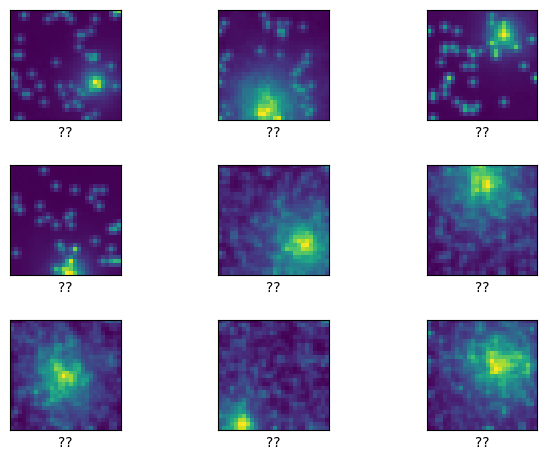

In [12]:
# Look at some processed samples! 

n_samples = 9
samples = SkyGenerator(n_samples=n_samples, batch_size=1, pre_processing=processor)
plot_samples(samples)

## Make the binary classification model 

This function, when called, produces a keras Model instance that you can train to predict a class of an input. 
Because this is a binary predictor, it can be used to pick if an image is closer to being class 0 or class 1. 
It takes an input of a certain shape, (defined by the `in_layer`), fits it to a convolution operation, and gives you a number (or array!) back out. 
The way this becomes a predictive engine is through the loss, of the output of the model will minimize a loss function, and give us a prediction that matches the data we fed it. 

In this case, what we want: 
* Take the input images from the data generator 
* Apply two convolutional blocks to the input image 
* Decode the second convolution block's output to a probability of the image being a given class. 

In [13]:
def make_model(): 
    
    # Define the input size
    in_layer = Input((28, 28))

    # Perform some convolutions 
    x = Conv1D(filters=4, kernel_size=2)(in_layer)
    x = Conv1D(filters=8, kernel_size=4)(x)
    x = Conv1D(filters=12, kernel_size=6)(x)
    
    x = AvgPool1D(6)(x)

    x = Conv1D(filters=4, kernel_size=2)(in_layer)
    x = Conv1D(filters=8, kernel_size=4)(x)
    x = Conv1D(filters=12, kernel_size=6)(x)
    
    x = AvgPool1D(6)(x)

    x = Flatten()(x)
    # Decode the convolutional output into an array
    x = Dense(20, activation='relu')(x)

    x = Dropout(0.3)(x)

    # Get the output class probabilities 
    output = Dense(1, activation='sigmoid')(x)
    model = Model(in_layer, output)
    
    return model

model = make_model()
loss = tf.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.SGD(0.01)

# Compile tells the keras backend what loss and optimizer to use to perform gradients on the model
# You cannot train a keras model without compiling it first
model.compile(loss=loss, optimizer=optimizer)

# Show what layers are in the model, and their input and output shapes 
# This can help make sure all your stuff is a correct size
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 27, 4)          │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 24, 8)          │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 19, 12)         │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 3, 12)          │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,713 (6.69 KB)

 Trainable params: 1,713 (6.69 KB)

 Non-trainable params: 0 (0.00 B)

# Train the model 

We have all the pieces in place:
- [x] Model 
- [x] Train Data 
- [x] Validation Data 
- [x] Loss Function 
- [x] Optimizer 

Now lets put this together into a fit model. 
Keras trains in place, so you don't need a new variable to hold the `fit_model` vs `model`. 
Once you call `fit`, the model is fit, and it re-train, you need to make a new model with the `make_model()` function. 

In [14]:
history = model.fit(
    train_generator_scaled, 
    validation_data=val_generator_scaled, 
    epochs=50, 
    verbose=1
    ).history


Epoch 1/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 6s 344ms/step - loss: 0.7196

/Users/maggiev-local/miniforge3/envs/ss_tutorials/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7027

/Users/maggiev-local/miniforge3/envs/ss_tutorials/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.7016 - val_loss: 0.6924
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.6935 - val_loss: 0.6898
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.6845 - val_loss: 0.6854
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.6825 - val_loss: 0.6820
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.6904 - val_loss: 0.6772
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.6820 - val_loss: 0.6696
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.6686 - val_loss: 0.6584
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.6683 - val_loss: 0.6519
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.6617 - val_loss: 0.6364
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.6537 - val_loss: 0.6176
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.6292 - val_loss: 0.5954
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.5707 - val_l

## Model Evaluation 

There are some steps we can take to see how well a model trained. 

### Loss Plots 
Obvious one is to see how the loss progressed - if the loss was still trending down when the training stopped, it would make sense that the model would benefit from longer training. 
Or, if the loss never moves or blows up entirely, that's a sign there's a problem. 
Looking at the [common pitfalls notebook](https://github.com/BNL-Fermilab-RENEW/tutorials_2024/blob/main/07_Challenge/common_pitfalls.ipynb) may help diagnose your problems! 

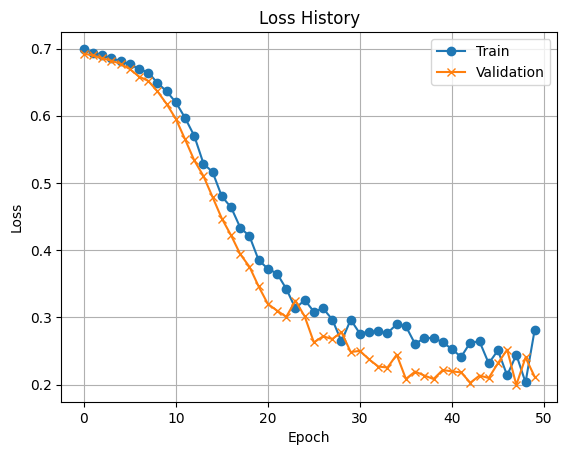

In [15]:
Eval.plot_loss_history(history) 
# Eval.plot_history is a simple function 
# plots the loss as a function of epoch 

## Classification Accuracy Plots 

After we did all this work to train a model, we need to be able to report how good it is on data we didn't use in training. 
For this, we'll make a new set of data (or use some data we held out from training), and run a few evaluation metrics on it. 

### ROC
The `receiver operating characteristic curve` (or just "ROC" (pronounced "Rock") Curve) is a metric that plots the true positive rate against the false positive rate. 
It shows how likely a model is to correctly predict something. 
The idea is that a classifier a better classifier will have lower false positive rate, and a higher true positive rate, so the curve will get closer and closer to the upper left corner as the prediction improves. 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/800px-Roc_curve.svg.png" width="300">

<a href="https://upload.wikimedia.org/wikipedia/commons/3/36/Roc-draft-xkcd-style.svg"></a><a href="//commons.wikimedia.org/wiki/File:Roc-draft-xkcd-style.svg#filelinks" title="File:Roc-draft-xkcd-style.svg">Roc-draft-xkcd-style.svg</a>, <a href="https://creativecommons.org/licenses/by-sa/4.0" title="Creative Commons Attribution-Share Alike 4.0">CC BY-SA 4.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=109730045">Link</a>


### Confusion Matrix

Confusion matrices are a great tool for seeing how well each class does against each other. 
It gets it name from its ability to tell if a model is "confusing" two different classes. 
It plots the rate of predicted values for a given class versus the true values. 

<img src="https://www.ibm.com/content/dam/connectedassets-adobe-cms/worldwide-content/creative-assets/s-migr/ul/g/c8/a7/binary-matrix.component.complex-narrative-xl.ts=1712087356966.png/content/adobe-cms/us/en/topics/confusion-matrix/jcr:content/root/table_of_contents/body/content_section_styled/content-section-body/complex_narrative_390941229/items/content_group/image" width='400'>

 <a href="https://www.ibm.com/topics/confusion-matrix">Link</a>

 A good confusion matrix will have very high values in the green boxes, and lower values in the red boxes. 

In [16]:
test_generator = SkyGenerator(n_samples=1280, train=False, shuffle=True, pre_processing=processor)

def make_prediction(test_generator): 
    predictions = model.predict(test_generator)
    prediction_classes = np.where(predictions<0.5, 0, 1)
    labels = test_generator.labels
    return prediction_classes, labels

def test_quality(prediction, labels): 
    accuracy = tf.keras.metrics.BinaryAccuracy()(prediction, labels)
    return accuracy.numpy()

prediction, labels = make_prediction(test_generator)
print(f"The binary classification accuracy on the test set is: {test_quality(prediction, labels)}")

 4/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/Users/maggiev-local/miniforge3/envs/ss_tutorials/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
The binary classification accuracy on the test set is: 0.891406238079071


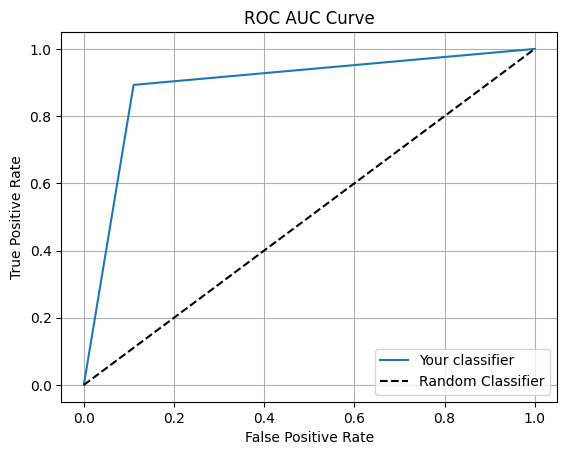

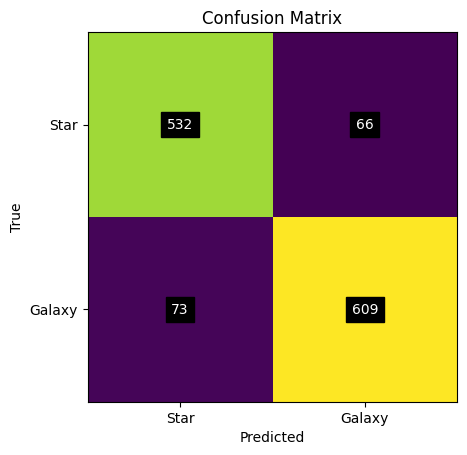

In [17]:
# And now run them on your own data! 
Eval.ROC_curve(prediction, labels)
Eval.confusion_matrix(prediction, labels)